## <ins style = "color : orange">Report by KHOUTAIBI Iliass and BARAKA Rayane: </ins>

In this report we will implement a variant of DUET method aiming to seperate sound sources in a stereophonic mixture.
Before starting we encountered an issue using the imdct function, if you encounter the same one please consider applying this changes in your python mdct lib file:


<ins style = "color : red"> <strong>WARNING !!!</strong>: In stft/utils.py file modify both functions: center_unpad and unpad, by changing: return data[slicetuple] to return data[tuple(slicetuple)]

Let's first import dependancies and some usefull functions for the signals' analysis

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile
import scipy.signal as signal
from scipy.spatial.distance import cdist

import IPython.display as ipd
from mdct.fast import mdct, imdct
from scipy.io.wavfile import write

plt.rcParams['figure.figsize'] = (12,8)

In [2]:
# useful functions

def plot_sound(data, rate, title=None):
    if data.ndim == 1:
        data = data[:,np.newaxis]
    times = np.arange(data.shape[0])/rate
    plt.figure(figsize=(30,6))
    for channel in data.T:
        plt.fill_between(times, channel)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(times[0], times[-1])
    if title:
        plt.title(title)
    plt.show()
    
def play_sound(data, rate):
    return ipd.display(ipd.Audio(data.T, rate=rate))

Let's first plot and play our initial mix

T = 220501, M = 2


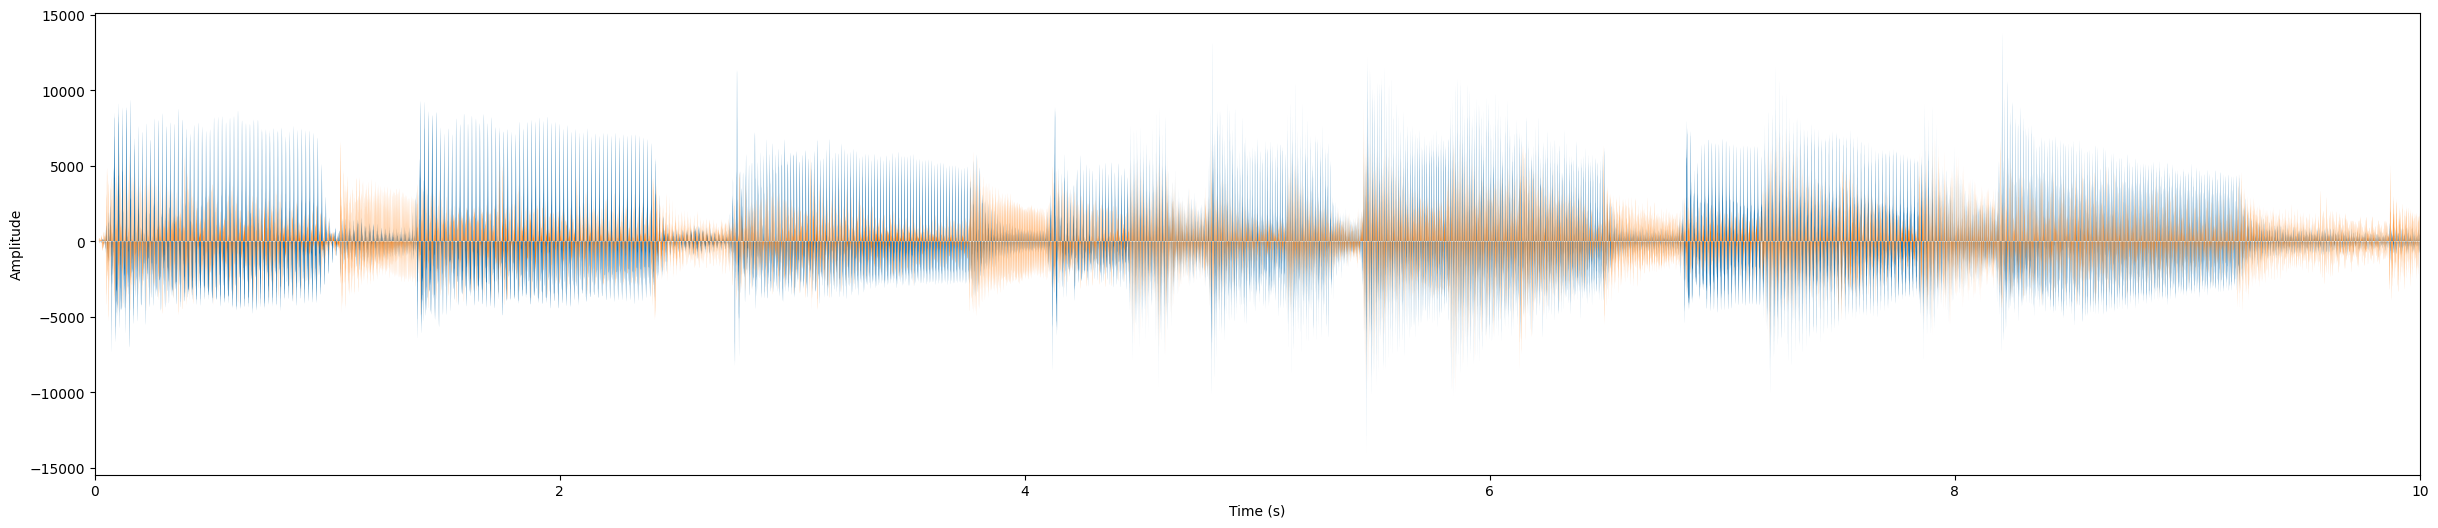

In [3]:
fname = 'mix.wav'

rate, x = wavfile.read(fname)
print('T = {:d}, M = {:d}'.format(*x.shape))
plot_sound(x, rate)
play_sound(x, rate)

### 1. We notice three distinct sources: two guitars and one piano. The piano's sound seems to come from all around the listener, while the high-pitched guitar appears to come from the right and the low-pitched guitar from the left.

In [4]:
write('new_mix.wav', rate, np.array(x, dtype=np.int16)) # to write a new wave file

### 2. Now let's plot the temporal dispersion diagram of our audio file

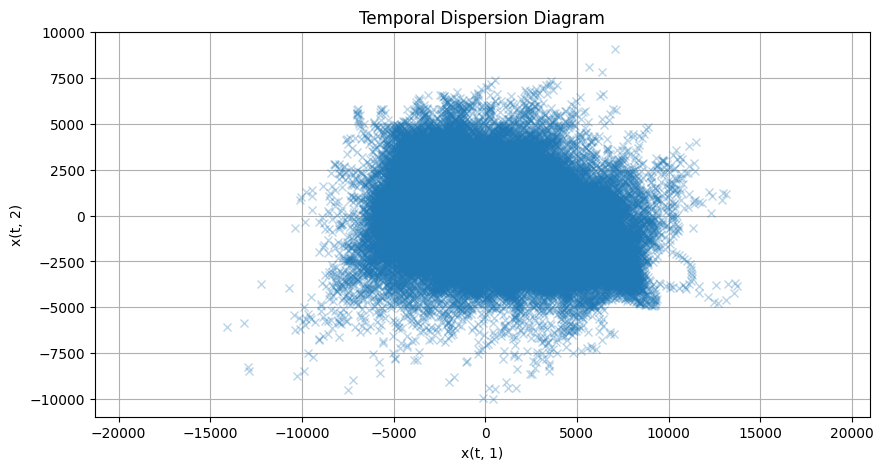

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(x[:, 0], x[:, 1], 'x', alpha=0.3)
plt.xlabel('x(t, 1)')
plt.ylabel('x(t, 2)')
plt.title('Temporal Dispersion Diagram')
plt.axis('equal')
plt.grid(True)
plt.show()

No directions are noticeable in this graph at this point

### 3. MDCT

Now let's commpute and plot the mdct of our signal 

(256, 863, 2) (256, 863)


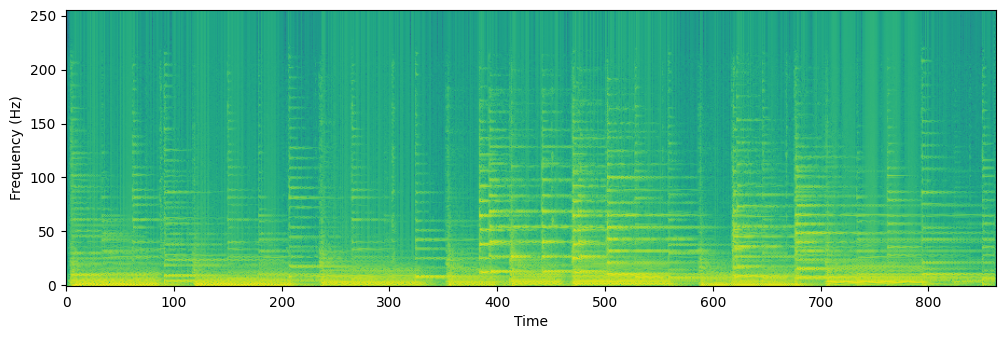

In [7]:
X = mdct(x, window=signal.windows.hamming, framelength=512)
Z = X.view(dtype=np.complex128)[...,0]

print(X.shape, Z.shape)

X_norm = np.abs(Z)**2


plt.imshow(np.log(X_norm+1e-10), origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.show()

### 4. Time-Frequency diagram of the MDCT

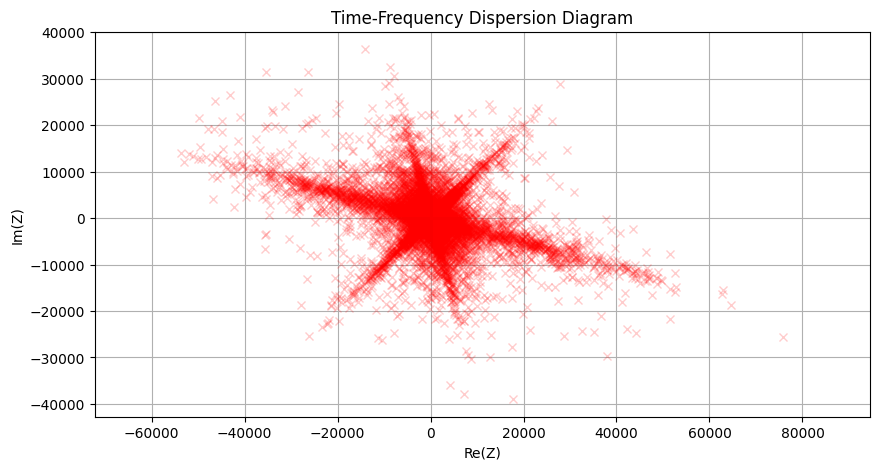

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(Z.real.flatten(), Z.imag.flatten(), 'x', color= "red", alpha=0.2)
plt.xlabel('Re(Z)')
plt.ylabel('Im(Z)')
plt.title('Time-Frequency Dispersion Diagram')
plt.axis('equal')
plt.grid(True)
plt.show()

Now, we clearly notice 3 sources, two diagonal ones and one horizontal one which appears to be the major source. In the fourier domain the sources are separable since the angle becomes a complex phase in the fourier domain that we notice while plotting the time-frequency dispersion diagram

In [9]:
angles = np.arctan(Z.imag.flatten() / (Z.real.flatten() + 1e-10))

### 5. Histogram

Now we want to get the precise orientations of the sources, we will therefore plot a histogram to get an idea of the density of Z's angles

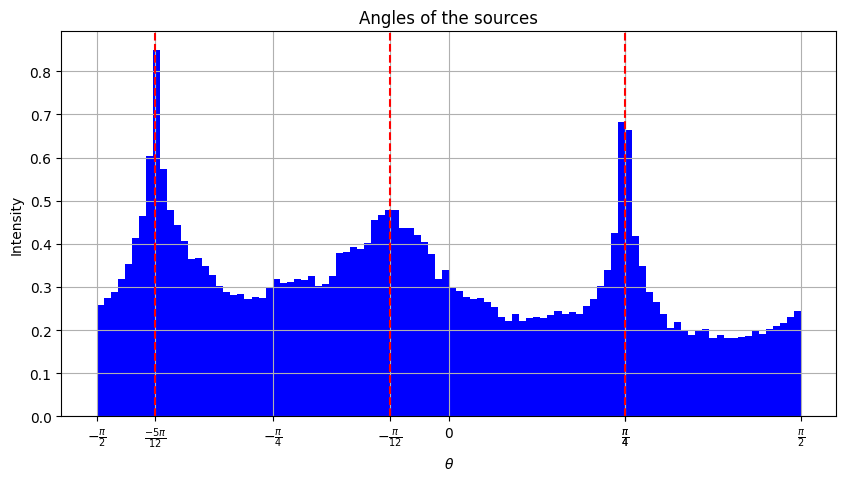

In [25]:
plt.figure(figsize=(10, 5))
plt.title("Angles of the sources")
plt.xlabel(r"$\theta$")
plt.ylabel("Intensity")
plt.hist(angles, color='blue', density=True, bins=100)
plt.axvline(np.pi/4, color='r', linestyle='--')
plt.axvline(-np.pi/12, color='r', linestyle='--')
plt.axvline(-5*np.pi/12, color='r', linestyle='--')
plt.xticks(np.concatenate((np.linspace(-np.pi/2, np.pi/2, 5), [np.pi/4, -np.pi/12, -5*np.pi/12])), labels=[r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{\pi}{4}$', r'$-\frac{\pi}{12}$', r'$\frac{-5\pi}{12}$'])
plt.grid()
plt.show()

We notice three pics at : $\frac{-5\pi}{12}$, $\frac{-\pi}{12}$ and $\frac{\pi}{4}$.

### 6. Here we will compute the source regions by considering the metric $|\sin(\theta(k) - \angle Z(f,n))|$ and computing all the distances to compute the masks we will use on our mdct to distinguish our sources

In [26]:
import numpy as np


theta = np.array([-5*np.pi/12, -np.pi/12, np.pi/4])
F, N = Z.shape
K = len(theta)

B = np.zeros((F, N, K), dtype=np.complex128)

angle_Z = np.angle(Z)  


for k in range(K):

    diff = theta[k] - angle_Z
    distance = np.abs(np.sin(diff))
    

    if k == 0:
        all_distances = distance[..., np.newaxis]
    else:
        all_distances = np.concatenate((all_distances, distance[..., np.newaxis]), axis=2)


closest_k = np.argmin(all_distances, axis=2) 


for k in range(K):
    B[:, :, k] = (closest_k == k)


In [27]:
Y = np.zeros((X.shape[0], X.shape[1], X.shape[2], 3), dtype=np.complex128)  # shape (F, N, M, K)
for k in range(K):
    for m in range(2):  
        Y[:, :, m, k] = Z * B[:, :, k]

### 7. Let's apply B on the mdct to get our seperate sources

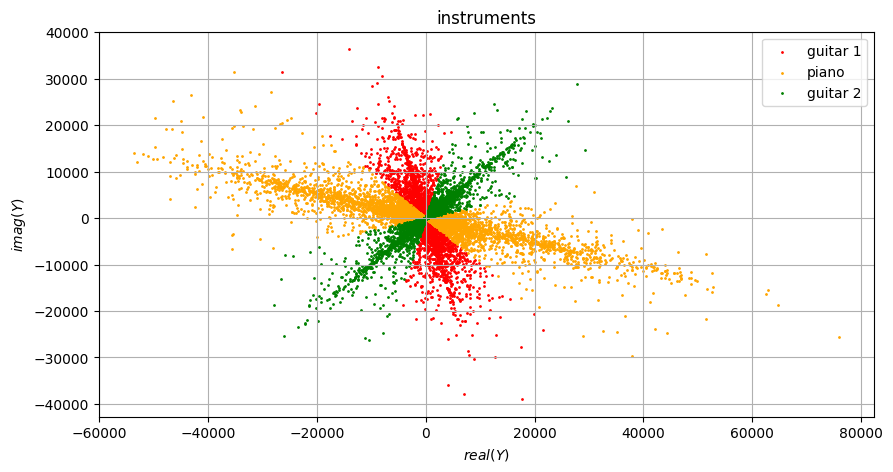

In [34]:
plt.figure(figsize=(10, 5))
plt.scatter(Y[:, :, 1, 0].real.flatten(), Y[:, :, 1, 0].imag.flatten(), color='red', label='guitar 1', s = 1)
plt.scatter(Y[:, :, 1, 1].real.flatten(), Y[:, :, 1, 1].imag.flatten(), color='orange', label='piano', s = 1)
plt.scatter(Y[:, :, 1, 2].real.flatten(), Y[:, :, 1, 2].imag.flatten(), color='green', label='guitar 2', s = 1)

plt.legend()
plt.title("instruments")
plt.xlabel(r"$real(Y)$")
plt.ylabel(r"$imag(Y)$")
plt.grid()
plt.show()

Now let's reconstruct the obtained signals to retrieve the sources sound.

In [35]:
y0 = imdct(Y[:, :, :, 0], window = signal.windows.hamming, framelength=512)
y1 = imdct(Y[:, :, :, 1], window = signal.windows.hamming, framelength=512)
y2 = imdct(Y[:, :, :, 2], window = signal.windows.hamming, framelength=512) 
y0.shape

(220672, 2)

In [37]:
A = np.zeros(shape=(3, 2))
A[0] = [np.cos(theta[0]), np.sin(theta[0])]
A[1] = [np.cos(theta[1]), np.sin(theta[1])]
A[2] = [np.cos(theta[2]), np.sin(theta[2])]

In [38]:
y0 *= A[0].T
y1 *= A[1].T
y2 *= A[2].T

In [39]:
write('source_1.wav', rate, np.array(y0, dtype=np.int16))
write('source_2.wav', rate, np.array(y1, dtype=np.int16))
write('source_3.wav', rate, np.array(y2, dtype=np.int16))

### 8. Let's listen to our obtained production

In [40]:
play_sound(y0, rate)
play_sound(y1, rate)
play_sound(y2, rate)

Besides some artifacts and a noticeable echo on the piano signal, the reconstructions gives us the very distinct instruments we heard in the beginning

### 9. Now let's compute the MMSE Estimator by multiplying our vector $\begin{pmatrix} y_x & y_y \end{pmatrix}$ by $\begin{pmatrix} \cos(\theta) \\ \sin(\theta) \end{pmatrix}$. We will then apply imdct to reconstruct our original signals

In [42]:
# MMSE Estimator 
F, N = Z.shape

S = np.zeros((F,N, 3)).astype(np.complex128) 

for k in range(N):
    for f in range(F):
        for i in range(3):
            S[f,k,i] = np.dot(Y[f,k,:,i],A[i])

s0 = imdct(S[:, :, 0], window=signal.windows.hamming, framelength=512)
s1 = imdct(S[:, :, 1], window=signal.windows.hamming, framelength=512)
s2 = imdct(S[:, :, 2], window=signal.windows.hamming, framelength=512)


# S_hat now contains the MMSE estimates for each source at each TF bin

In [43]:
play_sound(s0,rate)
play_sound(s1,rate)
play_sound(s2,rate)

## 10. Modifying the angles

We will now try to permute the directions of the sources to check the effects on reconstruction. Let us for instace multiply $Z$ by $\exp(i\frac{\pi}{2})$ and see what changes.

In [45]:
# Multiplying by exp(i pi/2)
Z_copy = Z.copy()
Z_copy *= np.exp(1j* np.pi/2)
X_rotated = np.zeros(X.shape)

X_rotated[:, :, 0] = Z_copy.real
X_rotated[:, :, 1] = Z_copy.imag

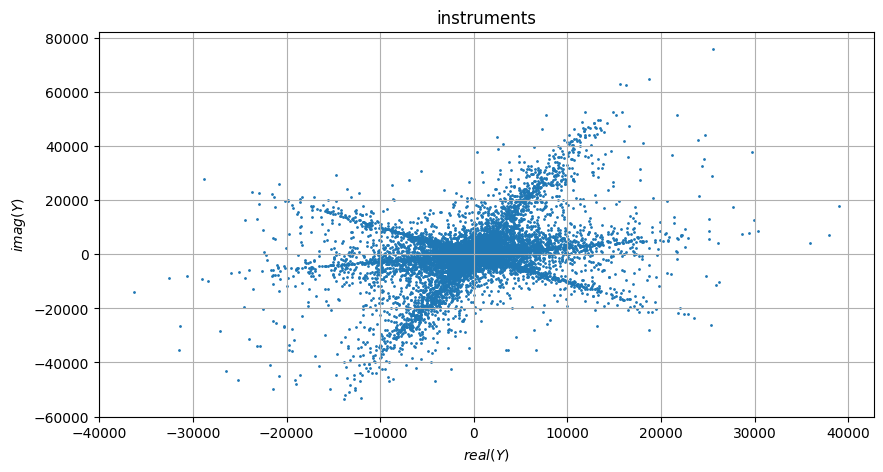

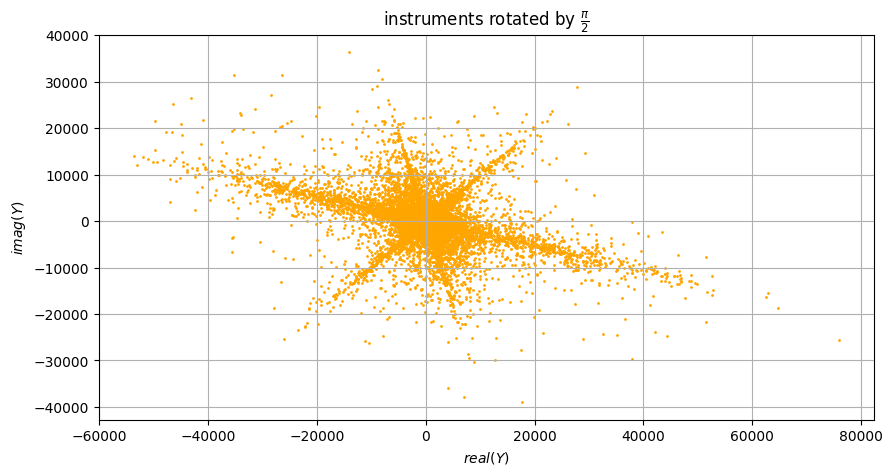

In [50]:
X1 = X_rotated[:, :, 0]
X2 = X_rotated[:, :, 1]

plt.figure(figsize=(10, 5))
plt.scatter(X1, X2, s = 1)
plt.title("instruments")
plt.xlabel(r"$real(Y)$")
plt.ylabel(r"$imag(Y)$")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(Z.real.flatten(), Z.imag.flatten(), s = 1, color = 'orange')
plt.title(r"instruments rotated by $\frac{\pi}{2}$")
plt.xlabel(r"$real(Y)$")
plt.ylabel(r"$imag(Y)$")
plt.grid()
plt.show()

As we can see, our instruments have been rotated by an angle of $\frac{\pi}{2}$. Let us check if that is the case in the reconstructed audio.

In [51]:
x_reconstructed = imdct(X_rotated, window = signal.windows.hamming, framelength=512)
play_sound(x_reconstructed, rate)

Great! notice how we now hear the first guitar in our left ear rather than our right ear, and vice versa for the second guitar. This shows that are instruments have indeed been rotated.

We can thus conclude from this TP session, the means to seperate the audio sources in one audio file, to estimate them using the MMSE estimator and how a phase multiplication affects the orientation of the sound sources.